# SAC

In [1]:
import math
import random
import sys

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from tensorboardX import SummaryWriter

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

# Networks

In [2]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [3]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        print("Mu", mean)
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

# Memory

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [7]:
class ReplayBufferTest(object):
    """Buffer to store tuples of experience replay"""
    
    def __init__(self, max_size=1000000):
        """
        Args:
            max_size (int): total amount of tuples to store
        """
        
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        """Add experience tuples to buffer
        
        Args:
            data (tuple): experience replay tuple
        """
        
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Samples a random amount of experiences from buffer of batch size
        
        Args:
            batch_size (int): size of sample
        """
        
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        states, actions, next_states, rewards, dones = [], [], [], [], []

        for i in ind: 
            s, a, s_, r, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            next_states.append(np.array(s_, copy=False))
            rewards.append(np.array(r, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(rewards).reshape(-1, 1), np.array(next_states),np.array(dones).reshape(-1, 1)

In [8]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [9]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

# Agent

In [10]:
class SAC(object):
    
    def __init__(self, state_dim, action_dim,env):
        
        self.action_dim = action_dim
        self.state_dim  = state_dim
        self.hidden_dim = 256

        self.value_net        = ValueNetwork(self.state_dim, self.hidden_dim).to(device)
        self.target_value_net = ValueNetwork(self.state_dim, self.hidden_dim).to(device)

        self.soft_q_net1 = SoftQNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.soft_q_net2 = SoftQNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, self.hidden_dim).to(device)

        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)


        self.value_criterion  = nn.MSELoss()
        self.soft_q_criterion1 = nn.MSELoss()
        self.soft_q_criterion2 = nn.MSELoss()

        self.value_lr  = 3e-4
        self.soft_q_lr = 3e-4
        self.policy_lr = 3e-4

        self.value_optimizer  = optim.Adam(self.value_net.parameters(), lr=self.value_lr)
        self.soft_q_optimizer1 = optim.Adam(self.soft_q_net1.parameters(), lr=self.soft_q_lr)
        self.soft_q_optimizer2 = optim.Adam(self.soft_q_net2.parameters(), lr=self.soft_q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.policy_lr)


        replay_buffer_size = 1000000
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.test_buffer = ReplayBufferTest(replay_buffer_size)
    
    def select_action(self,state):
        action = self.policy_net.get_action(state).detach()
        print(action)
        return action
        
        
    def update(self, batch_size, iterations, gamma=0.99,soft_tau=1e-2,):
        
        for _ in range(iterations):
        
            state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
            
            statet, actiont, rewardt, next_statet, donet = self.test_buffer.sample(batch_size)
            
#             print("Main {}{}{}{}{}".format(state.shape, action.shape, reward.shape, next_state.shape, done.shape))
#             print("Test {}{}{}{}{}".format(statet.shape, actiont.shape, rewardt.shape, next_statet.shape, donet.shape))
            
            state      = torch.FloatTensor(state).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            action     = torch.FloatTensor(action).to(device)
            reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
            done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

            predicted_q_value1 = self.soft_q_net1(state, action)
            predicted_q_value2 = self.soft_q_net2(state, action)
            predicted_value    = self.value_net(state)
            new_action, log_prob, epsilon, mean, log_std = self.policy_net.evaluate(state)



        # Training Q Function
            target_value = self.target_value_net(next_state)
            target_q_value = reward + (1 - done) * gamma * target_value
            q_value_loss1 = self.soft_q_criterion1(predicted_q_value1, target_q_value.detach())
            q_value_loss2 = self.soft_q_criterion2(predicted_q_value2, target_q_value.detach())


            self.soft_q_optimizer1.zero_grad()
            q_value_loss1.backward()
            self.soft_q_optimizer1.step()
            self.soft_q_optimizer2.zero_grad()
            q_value_loss2.backward()
            self.soft_q_optimizer2.step()  

        # Training Value Function
            predicted_new_q_value = torch.min(self.soft_q_net1(state, new_action),self.soft_q_net2(state, new_action))
            target_value_func = predicted_new_q_value - log_prob
            value_loss = self.value_criterion(predicted_value, target_value_func.detach())


            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()
        # Training Policy Function
            policy_loss = (log_prob - predicted_new_q_value).mean()

            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()


            for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )
        
    

# Runner

In [11]:
class Runner():
    """Carries out the environment steps and adds experiences to memory"""
    
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
#         self.replay_buffer = replay_buffer
        self.obs = env.reset()
        self.done = False
        
    def next_step(self, episode_timesteps, noise=0.1):
        
        action = self.agent.select_action(self.obs)
        print(action)
        print("end")
        

        # Perform action
        # TODO: Clean up get action 
        new_obs, reward, done, _ = self.env.step(action.numpy()) 
        done_bool = 0 if episode_timesteps + 1 == 200 else float(done)
    
        # Store data in replay buffer
#         replay_buffer.add((self.obs, new_obs, action, reward, done_bool))
#         print("New State: ",new_obs.shape)
        self.agent.replay_buffer.push(self.obs, action, reward, new_obs, done_bool)
        self.agent.test_buffer.add([self.obs, action, reward, new_obs, done_bool])
        
        self.obs = new_obs
        
        if done:
            self.obs = self.env.reset()
            done = False
            
            return reward, True
        
        return reward, done

# Observe

In [12]:
def observe(env, agent, observation_steps):
    """run episodes while taking random actions and filling replay_buffer
    
        Args:
            env (env): gym environment
            replay_buffer(ReplayBuffer): buffer to store experience replay
            observation_steps (int): how many steps to observe for
    
    """
    
    time_steps = 0
    obs = env.reset()
    done = False

    while time_steps < observation_steps:
        action = env.action_space.sample()
        new_obs, reward, done, _ = env.step(action)

        agent.replay_buffer.push(obs, action, reward, new_obs, done)
        agent.test_buffer.add([obs, action, reward, new_obs, done])

        obs = new_obs
        time_steps += 1

        if done:
            obs = env.reset()
            done = False

        print("\rPopulating Buffer {}/{}.".format(time_steps, observation_steps), end="")
        sys.stdout.flush()

# Train

In [13]:
def train(agent, test_env):
    """Train the agent for exploration steps
    
        Args:
            agent (Agent): agent to use
            env (environment): gym environment
            writer (SummaryWriter): tensorboard writer
            exploration (int): how many training steps to run
    
    """

    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    episode_reward = 0
    episode_timesteps = 0
    done = False 
    obs = env.reset()
    evaluations = []
    rewards = []
    best_avg = -2000
    
    writer = SummaryWriter(comment="-TD3_Baseline_HalfCheetah")
    
    while total_timesteps < EXPLORATION:
    
        if done: 

            if total_timesteps != 0: 
                rewards.append(episode_reward)
                
                if total_timesteps % 1000 == 0:
                    plot(len(rewards), rewards)
                
                avg_reward = np.mean(rewards[-100:])
                
                writer.add_scalar("avg_reward", avg_reward, total_timesteps)
                writer.add_scalar("reward_step", reward, total_timesteps)
                writer.add_scalar("episode_reward", episode_reward, total_timesteps)
                
                print("\rTotal T: {:d} Episode Num: {:d} Reward: {:f} Avg Reward: {:f}".format(
                    total_timesteps, episode_num, episode_reward, avg_reward), end="")
                sys.stdout.flush()


                if avg_reward >= REWARD_THRESH:
                    break

#                 agent.update(replay_buffer, episode_timesteps, BATCH_SIZE, GAMMA, TAU, NOISE, NOISE_CLIP, POLICY_FREQUENCY)
                agent.update(100,episode_timesteps)

                episode_reward = 0
                episode_timesteps = 0
                episode_num += 1 

        reward, done = runner.next_step(episode_timesteps)
        episode_reward += reward

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1
        
#         agent.update(128)
        
        

# Config

In [14]:
ENV = "Pendulum-v0"
SEED = 0
OBSERVATION = 100
EXPLORATION = 40000
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.1
POLICY_FREQUENCY = 2
EVAL_FREQUENCY = 5000
REWARD_THRESH = -100

# Main

In [15]:
env = NormalizedActions(gym.make(ENV))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds
env.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

agent = SAC(state_dim, action_dim, env)

# replay_buffer = ReplayBuffer()

runner = Runner(env, agent)

total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True

In [16]:
# Populate replay buffer
observe(env, agent, OBSERVATION)

Populating Buffer 100/100.

/Users/donal/gym/gym/logger.py:30: UserWarning: WARN: <class '__main__.NormalizedActions'> doesn't implement 'action' method. Maybe it implements deprecated '_action' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


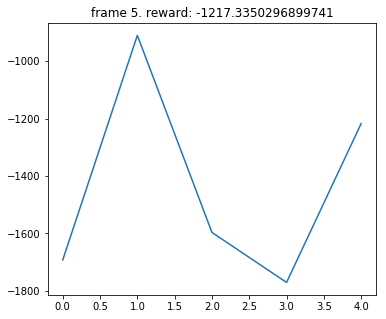

Total T: 1000 Episode Num: 4 Reward: -1217.335030 Avg Reward: -1437.540224Mu tensor([[-1.9891e-01],
        [-9.8929e-02],
        [-2.3622e-01],
        [-6.2938e-02],
        [-2.6931e-01],
        [ 2.1558e-03],
        [-4.5236e-01],
        [-3.0671e-01],
        [ 9.3013e-02],
        [-1.4287e-02],
        [-1.8350e-02],
        [-3.3044e-01],
        [-8.1295e-02],
        [-4.1810e-01],
        [-3.0910e-01],
        [ 1.4703e-01],
        [-5.1700e-01],
        [-4.5256e-01],
        [-2.7301e-01],
        [-3.2326e-01],
        [-3.7679e-01],
        [ 5.2709e-02],
        [ 2.4609e-02],
        [ 1.1697e-02],
        [-2.6115e-01],
        [-1.2752e-02],
        [-4.6200e-02],
        [-4.9437e-02],
        [ 1.9626e-01],
        [-4.5404e-01],
        [ 6.6466e-02],
        [ 2.7683e-03],
        [-5.0538e-01],
        [-1.2185e-01],
        [-2.2794e-01],
        [ 8.4426e-02],
        [ 9.4070e-02],
        [-2.7436e-01],
        [ 1.0288e-01],
        [ 2.0503e-01],
   

Mu tensor([[ 0.2801],
        [-0.2502],
        [-0.1494],
        [ 0.4591],
        [-0.0118],
        [ 0.3353],
        [-0.2196],
        [-0.0061],
        [ 0.3517],
        [-0.0216],
        [-0.2139],
        [ 0.0045],
        [ 0.2407],
        [-0.1502],
        [-0.0370],
        [ 0.0396],
        [ 0.4298],
        [-0.1209],
        [-0.2970],
        [-0.0161],
        [ 0.1370],
        [-0.2089],
        [-0.0713],
        [ 0.3008],
        [-0.2550],
        [-0.3204],
        [ 0.0310],
        [-0.0027],
        [ 0.0519],
        [-0.1015],
        [-0.2389],
        [ 0.1714],
        [ 0.1741],
        [ 0.0875],
        [-0.1066],
        [-0.2986],
        [-0.0189],
        [ 0.2073],
        [-0.0506],
        [-0.1179],
        [ 0.0119],
        [ 0.2307],
        [-0.2706],
        [-0.0780],
        [-0.4518],
        [ 0.3608],
        [ 0.0398],
        [-0.3904],
        [-0.3109],
        [ 0.0914],
        [ 0.0868],
        [ 0.3060],
        [

Mu tensor([[-0.4107],
        [-0.2396],
        [ 0.0237],
        [ 0.2007],
        [ 0.3518],
        [-0.0467],
        [-0.2754],
        [-0.2950],
        [ 0.5622],
        [ 0.0186],
        [-0.3593],
        [ 0.0359],
        [-0.0871],
        [-0.0408],
        [ 0.4341],
        [-0.0190],
        [-0.3090],
        [ 0.0674],
        [ 0.0509],
        [-0.4643],
        [-0.1676],
        [-0.4420],
        [-0.5975],
        [ 0.3795],
        [-0.0719],
        [ 0.0538],
        [ 0.0685],
        [ 0.1364],
        [ 0.1317],
        [ 0.4878],
        [-0.1451],
        [-0.0674],
        [-0.3657],
        [ 0.1996],
        [ 0.1352],
        [ 0.1351],
        [ 0.0681],
        [-0.2533],
        [ 0.2459],
        [ 0.1188],
        [-0.2079],
        [-0.4947],
        [ 0.0147],
        [ 0.0528],
        [-0.0454],
        [-0.0642],
        [-0.5290],
        [ 0.3022],
        [-0.2357],
        [-0.5107],
        [ 0.0874],
        [-0.5386],
        [

Mu tensor([[-0.0135],
        [ 0.3977],
        [ 0.1473],
        [-0.1871],
        [-0.5050],
        [ 0.2014],
        [-0.6290],
        [-0.4037],
        [ 0.0418],
        [ 0.5228],
        [-0.4492],
        [ 0.4396],
        [-0.1908],
        [ 0.2077],
        [ 0.3576],
        [ 0.1204],
        [ 0.2414],
        [-0.1305],
        [-0.4594],
        [-0.1873],
        [-0.6641],
        [-0.5956],
        [-0.1854],
        [ 0.3063],
        [-0.1593],
        [ 0.1719],
        [ 0.3034],
        [-0.5938],
        [ 0.3081],
        [-0.0040],
        [ 0.0773],
        [-0.0012],
        [ 0.0734],
        [ 0.2329],
        [ 0.0751],
        [-0.2065],
        [-0.2786],
        [-0.5110],
        [-0.2839],
        [ 0.2273],
        [ 0.0232],
        [-0.2502],
        [ 0.1206],
        [ 0.3067],
        [ 0.5250],
        [-0.1419],
        [-0.3334],
        [-0.4855],
        [-0.2850],
        [-0.2770],
        [ 0.2643],
        [-0.1914],
        [

Mu tensor([[-0.1362],
        [-0.0816],
        [-0.3289],
        [-0.7492],
        [-0.0928],
        [-0.0476],
        [-0.8558],
        [-0.2736],
        [-0.2159],
        [ 0.1408],
        [-0.2908],
        [-0.5130],
        [ 0.0943],
        [-0.4821],
        [-0.5862],
        [ 0.1620],
        [ 0.2757],
        [ 0.0650],
        [-0.0826],
        [-0.2234],
        [-0.6162],
        [-0.0197],
        [ 0.2957],
        [ 0.1300],
        [ 0.0408],
        [-0.0139],
        [-0.2304],
        [-0.0382],
        [-0.4650],
        [ 0.0900],
        [ 0.0933],
        [-0.1251],
        [ 0.0729],
        [-0.6426],
        [-0.4573],
        [-0.2902],
        [-0.3265],
        [-0.0562],
        [-0.0884],
        [ 0.0948],
        [-0.0078],
        [-0.8247],
        [ 0.3318],
        [-0.1278],
        [-0.1101],
        [-0.0145],
        [-0.0799],
        [-0.0673],
        [-0.4294],
        [-0.2497],
        [-0.1197],
        [-0.2537],
        [

Mu tensor([[ 0.0570],
        [ 0.3316],
        [-0.5278],
        [ 0.0467],
        [ 0.1658],
        [-0.0858],
        [-0.1999],
        [ 0.2010],
        [-0.4377],
        [-0.4382],
        [ 0.3951],
        [ 0.2293],
        [-0.0047],
        [-0.4002],
        [ 0.0602],
        [ 0.0944],
        [-0.2135],
        [-0.5418],
        [-0.3822],
        [-0.0399],
        [ 0.1203],
        [ 0.0971],
        [ 0.3758],
        [-0.7945],
        [-0.1636],
        [ 0.0997],
        [ 0.1055],
        [-0.2824],
        [ 0.0501],
        [-0.0362],
        [-0.5063],
        [-0.1297],
        [-0.8173],
        [ 0.1859],
        [ 0.0853],
        [-0.5282],
        [-0.7173],
        [-0.2703],
        [-0.4544],
        [ 0.2858],
        [-0.0037],
        [-0.1181],
        [ 0.3465],
        [-0.3000],
        [-0.1366],
        [-0.0220],
        [ 0.1480],
        [-0.1578],
        [-0.0312],
        [ 0.0660],
        [-0.4404],
        [-0.2426],
        [

Mu tensor([[ 0.1599],
        [-0.6006],
        [ 0.0938],
        [ 0.2178],
        [-0.3520],
        [ 0.0405],
        [-0.2449],
        [-0.1613],
        [ 0.2752],
        [ 0.5477],
        [-0.4725],
        [-0.3378],
        [-0.5856],
        [ 0.2834],
        [ 0.5455],
        [ 0.2794],
        [ 0.0528],
        [ 0.0647],
        [ 0.2338],
        [ 0.1207],
        [-0.2299],
        [-0.0583],
        [ 0.1985],
        [-0.0331],
        [-0.1420],
        [ 0.2220],
        [ 0.0594],
        [-0.2937],
        [ 0.5170],
        [ 0.3836],
        [-0.4646],
        [-0.6832],
        [ 0.1369],
        [ 0.1859],
        [-0.0214],
        [-0.3268],
        [ 0.1925],
        [-0.0692],
        [-0.0090],
        [-0.2434],
        [ 0.2900],
        [-0.5397],
        [ 0.0434],
        [ 0.1799],
        [-0.1654],
        [ 0.1944],
        [-0.0457],
        [-0.0136],
        [-0.0434],
        [ 0.2187],
        [ 0.3658],
        [ 0.4752],
        [

Mu tensor([[ 0.6970],
        [ 0.1789],
        [ 0.6220],
        [ 0.5516],
        [ 0.6474],
        [ 0.3935],
        [-0.2450],
        [ 0.3082],
        [ 0.1762],
        [ 0.1767],
        [ 0.5420],
        [-0.1006],
        [ 0.0510],
        [ 0.0293],
        [ 0.5976],
        [-0.0778],
        [-0.0056],
        [-0.1425],
        [ 0.3156],
        [ 0.5714],
        [ 0.2232],
        [-0.4208],
        [-0.1399],
        [ 0.2894],
        [-0.2618],
        [-0.1546],
        [ 0.1528],
        [ 0.8359],
        [-0.1396],
        [-0.4572],
        [-0.1275],
        [ 0.1812],
        [ 0.1345],
        [-0.2940],
        [ 0.0948],
        [ 0.6245],
        [-0.0333],
        [ 0.2465],
        [ 0.1891],
        [-0.0294],
        [ 0.2216],
        [-0.2264],
        [ 0.5960],
        [ 0.1661],
        [ 0.0763],
        [-0.4226],
        [ 0.2850],
        [ 0.0347],
        [ 0.5408],
        [ 0.5023],
        [-0.0815],
        [ 0.3400],
        [

Mu tensor([[ 0.3898],
        [-0.0474],
        [ 0.0263],
        [-0.3351],
        [-0.5156],
        [ 0.1704],
        [ 0.1133],
        [-0.0620],
        [ 0.1523],
        [-0.5159],
        [-0.3797],
        [ 0.6604],
        [ 0.4357],
        [-0.1416],
        [ 0.6609],
        [-0.6033],
        [ 0.1970],
        [ 0.2735],
        [-0.1367],
        [ 0.6056],
        [-0.0599],
        [-0.2917],
        [-0.2553],
        [ 0.2106],
        [ 0.3151],
        [ 0.5317],
        [ 0.0656],
        [-0.1925],
        [-0.5723],
        [ 0.3219],
        [ 0.2036],
        [-0.4258],
        [-0.5978],
        [-0.1982],
        [ 0.3290],
        [-0.0299],
        [ 0.0821],
        [ 0.0361],
        [-0.3554],
        [ 0.2791],
        [ 0.1024],
        [ 0.0103],
        [ 0.1231],
        [-0.1209],
        [-0.1637],
        [-0.2661],
        [ 0.2337],
        [ 0.1915],
        [-0.0895],
        [ 0.0221],
        [-0.1191],
        [-0.0703],
        [

Mu tensor([[ 0.0550],
        [-0.4118],
        [ 0.3850],
        [-0.1875],
        [ 0.3476],
        [ 0.0256],
        [ 0.4135],
        [ 0.6170],
        [-0.1465],
        [-0.6255],
        [-0.0244],
        [-0.0804],
        [ 0.3454],
        [ 0.1083],
        [ 0.1036],
        [ 0.0770],
        [ 0.6500],
        [-0.4588],
        [-0.5214],
        [-0.1356],
        [ 0.4241],
        [ 0.0017],
        [ 0.2513],
        [-0.4807],
        [ 0.3559],
        [ 0.2107],
        [ 0.3929],
        [ 0.3674],
        [-0.3256],
        [ 0.1203],
        [-0.4229],
        [ 0.0763],
        [ 0.1692],
        [ 0.1820],
        [ 0.0238],
        [-0.2455],
        [-0.3344],
        [ 0.1527],
        [ 0.0885],
        [-0.0381],
        [-0.2087],
        [-0.5919],
        [-0.3069],
        [ 0.0742],
        [ 0.3476],
        [ 0.3742],
        [-0.1598],
        [ 0.7814],
        [ 0.4409],
        [ 0.2791],
        [ 0.1368],
        [ 0.1963],
        [

Mu tensor([[ 0.5970],
        [ 0.1507],
        [-0.0479],
        [-0.6297],
        [ 0.1685],
        [-0.5598],
        [-0.2449],
        [ 0.1236],
        [ 0.1225],
        [ 0.2244],
        [-0.1800],
        [ 0.6966],
        [ 0.4859],
        [-0.4190],
        [ 0.1715],
        [ 0.2527],
        [ 0.2609],
        [ 0.2103],
        [ 0.3075],
        [ 0.4610],
        [-0.0622],
        [ 0.1584],
        [ 0.3536],
        [ 0.2025],
        [ 0.0830],
        [ 0.6495],
        [ 0.7428],
        [ 0.7534],
        [ 0.0900],
        [-0.3564],
        [ 0.3583],
        [ 0.1614],
        [-0.5059],
        [ 0.2963],
        [ 0.0017],
        [ 0.1631],
        [ 0.4710],
        [ 0.3860],
        [-0.3104],
        [-0.2209],
        [ 0.4317],
        [-0.6157],
        [-0.3241],
        [ 0.6117],
        [-0.6699],
        [ 0.6849],
        [-0.4573],
        [ 0.0520],
        [ 0.5355],
        [ 0.4736],
        [-0.2819],
        [ 0.2825],
        [

Mu tensor([[-0.0710],
        [-0.6871],
        [ 0.4976],
        [ 0.0010],
        [ 0.6175],
        [-0.2674],
        [-0.1188],
        [ 0.0232],
        [ 0.1328],
        [ 0.1849],
        [ 0.4231],
        [-0.2988],
        [ 0.6270],
        [-0.0490],
        [-0.7852],
        [ 0.1239],
        [ 0.2227],
        [-0.3135],
        [ 0.3930],
        [-0.2736],
        [-0.4190],
        [ 0.4859],
        [ 0.4337],
        [ 0.0187],
        [-0.2321],
        [ 0.1191],
        [ 0.1925],
        [-0.1806],
        [-0.1531],
        [ 0.0015],
        [-0.3913],
        [-0.0544],
        [ 0.0889],
        [-0.2513],
        [ 0.1219],
        [ 0.1444],
        [ 0.1217],
        [ 0.3693],
        [-0.5599],
        [-0.2705],
        [ 0.2004],
        [-0.6818],
        [ 0.3438],
        [-0.4175],
        [-0.6688],
        [-0.2656],
        [-0.3461],
        [-0.3762],
        [ 0.1298],
        [ 0.6764],
        [ 0.0117],
        [ 0.6851],
        [

Mu tensor([[ 0.0338],
        [ 0.2309],
        [-0.1706],
        [ 0.0947],
        [ 0.0560],
        [ 0.3263],
        [ 0.1693],
        [ 0.0745],
        [-0.5640],
        [ 0.2020],
        [ 0.8268],
        [-0.0361],
        [ 0.1752],
        [ 0.6871],
        [-0.2476],
        [-0.6771],
        [ 0.4472],
        [-0.1015],
        [ 0.3526],
        [ 0.1569],
        [ 0.0461],
        [ 0.4723],
        [-0.0125],
        [ 0.7858],
        [-0.2627],
        [-0.0055],
        [ 0.2705],
        [ 0.3927],
        [ 0.2019],
        [-0.0292],
        [ 0.8071],
        [-0.3793],
        [-0.7203],
        [ 0.3506],
        [ 0.2826],
        [ 0.3276],
        [-0.3579],
        [ 0.3432],
        [-0.2673],
        [-0.0159],
        [-0.2045],
        [ 0.5269],
        [ 0.5766],
        [ 0.5362],
        [ 0.3158],
        [-0.3145],
        [ 0.1432],
        [ 0.5163],
        [-0.1765],
        [ 0.0516],
        [ 0.1115],
        [ 0.1533],
        [

Mu tensor([[ 0.8996],
        [ 0.2188],
        [-0.2751],
        [ 0.2597],
        [-0.4439],
        [-0.2747],
        [-0.3726],
        [-0.2380],
        [ 0.4118],
        [-0.3441],
        [-0.5627],
        [ 0.2203],
        [-0.3292],
        [ 0.3100],
        [-0.5382],
        [ 0.2500],
        [ 0.7472],
        [ 0.3394],
        [-0.5956],
        [-0.5022],
        [-0.2261],
        [ 0.0998],
        [-0.5219],
        [-0.0399],
        [ 0.9219],
        [-0.4164],
        [ 0.1969],
        [ 0.8626],
        [-0.7969],
        [ 0.2632],
        [ 0.1723],
        [-0.4077],
        [-0.3649],
        [-0.5333],
        [ 0.2363],
        [ 0.1315],
        [ 0.2392],
        [ 0.2653],
        [-0.2670],
        [ 0.0984],
        [ 0.1746],
        [ 0.4532],
        [ 0.3239],
        [ 0.0480],
        [ 0.1740],
        [-0.3627],
        [ 0.1561],
        [ 0.0419],
        [-0.2878],
        [-0.3642],
        [ 0.8029],
        [-0.5188],
        [

Mu tensor([[-0.1073],
        [-0.0980],
        [-0.1506],
        [ 0.5501],
        [-0.1804],
        [-0.3452],
        [ 0.0117],
        [-0.8548],
        [ 0.5980],
        [ 0.1271],
        [ 0.0032],
        [-0.0517],
        [-0.3663],
        [-0.0413],
        [-0.0459],
        [ 0.0290],
        [-0.1023],
        [-1.2667],
        [-0.2979],
        [ 0.0207],
        [-0.1405],
        [-1.0673],
        [-0.3701],
        [ 0.1259],
        [-0.4738],
        [ 0.0934],
        [-0.1813],
        [-0.2147],
        [-0.4154],
        [ 0.0118],
        [-0.2239],
        [ 0.0249],
        [ 0.4158],
        [-0.0669],
        [ 0.0875],
        [-1.1906],
        [-0.0372],
        [-0.3733],
        [ 0.1898],
        [-0.4650],
        [-0.3820],
        [-0.2268],
        [-0.1126],
        [-0.3753],
        [ 0.4058],
        [ 0.1110],
        [ 0.3860],
        [-1.1192],
        [ 0.2266],
        [ 0.0930],
        [-0.3409],
        [-0.2608],
        [

Mu tensor([[-0.0635],
        [ 0.1774],
        [ 0.0333],
        [ 0.0702],
        [-0.4444],
        [ 0.0154],
        [-0.6975],
        [ 0.2149],
        [-0.1537],
        [ 0.5610],
        [-0.2698],
        [-0.0365],
        [-1.0723],
        [-0.1947],
        [-0.8152],
        [-0.1225],
        [-0.3804],
        [-0.0664],
        [ 0.0692],
        [ 0.1015],
        [ 0.0553],
        [-0.3204],
        [-0.3076],
        [ 0.4881],
        [-0.5427],
        [-0.0323],
        [-0.3033],
        [-0.1812],
        [ 0.2056],
        [ 0.0243],
        [-0.5371],
        [-0.7513],
        [ 0.4833],
        [ 0.1540],
        [-0.0894],
        [-0.2922],
        [-1.0027],
        [ 0.3464],
        [-0.9750],
        [ 0.2200],
        [-0.2151],
        [-0.6090],
        [ 0.1176],
        [-0.1111],
        [-0.2359],
        [-1.1424],
        [ 0.5583],
        [ 0.4739],
        [-0.2386],
        [-0.2724],
        [ 0.5737],
        [-0.3625],
        [

Mu tensor([[-4.6528e-01],
        [ 2.7839e-02],
        [ 1.0122e-01],
        [ 4.2179e-01],
        [-6.0293e-01],
        [-1.0444e-02],
        [ 3.6337e-01],
        [-1.9192e-01],
        [ 1.3340e-02],
        [ 3.7501e-01],
        [-2.9192e-01],
        [ 5.6755e-02],
        [ 5.1102e-01],
        [ 6.8327e-01],
        [-2.4557e-01],
        [ 1.5803e-01],
        [-5.7869e-02],
        [-7.1164e-02],
        [ 8.5477e-02],
        [ 2.3165e-01],
        [ 2.9750e-01],
        [-1.0089e-01],
        [-3.8689e-01],
        [ 5.9773e-01],
        [ 2.4703e-01],
        [ 8.5814e-02],
        [ 5.2254e-01],
        [ 1.6764e-04],
        [-5.0135e-01],
        [-9.0181e-03],
        [ 6.2335e-02],
        [-6.4395e-01],
        [-3.6124e-01],
        [-2.8475e-01],
        [ 1.3405e-01],
        [-1.7676e-01],
        [-2.8084e-01],
        [-1.4767e-01],
        [-9.8103e-01],
        [-4.1346e-02],
        [ 1.9289e-01],
        [ 2.5629e-02],
        [ 2.3092e-01],
        

Mu tensor([[-0.4253],
        [-0.1797],
        [-0.5601],
        [-0.0650],
        [-0.4873],
        [ 0.6464],
        [-0.0886],
        [-0.1628],
        [-0.4295],
        [ 0.3850],
        [-0.7845],
        [ 0.1609],
        [ 0.6760],
        [ 0.0264],
        [-0.0088],
        [-0.4574],
        [-0.0245],
        [-0.4831],
        [-0.1054],
        [ 0.4888],
        [-0.4652],
        [ 0.4259],
        [-0.3609],
        [-0.7551],
        [-0.8015],
        [ 0.0965],
        [-0.5162],
        [ 0.0748],
        [-0.4056],
        [ 0.1067],
        [-0.7445],
        [-0.4488],
        [-0.5391],
        [ 0.0490],
        [-0.4319],
        [ 0.5007],
        [-0.5212],
        [-0.2536],
        [ 0.0692],
        [ 0.0739],
        [-0.8507],
        [-0.2248],
        [ 0.6550],
        [-0.3919],
        [-0.9840],
        [ 0.4719],
        [-0.1280],
        [-0.1773],
        [ 0.3478],
        [ 0.2499],
        [ 0.4491],
        [ 0.2491],
        [

Mu tensor([[ 0.1020],
        [ 0.0490],
        [-0.5149],
        [ 0.7473],
        [ 0.2062],
        [-0.2547],
        [ 0.1722],
        [ 0.0403],
        [ 0.0559],
        [-0.9582],
        [-0.6010],
        [-1.0384],
        [ 0.0203],
        [-0.1700],
        [ 0.3820],
        [-0.1820],
        [ 0.6049],
        [ 0.6651],
        [-0.6884],
        [-0.3042],
        [-0.3967],
        [ 0.1048],
        [-0.1050],
        [-0.0777],
        [ 0.7398],
        [-0.0035],
        [ 0.6195],
        [ 0.1332],
        [ 0.2626],
        [-0.5743],
        [ 0.3965],
        [-0.1006],
        [-0.2872],
        [-0.5971],
        [-0.3019],
        [ 0.2188],
        [ 0.0452],
        [-0.4173],
        [ 0.0810],
        [-0.0777],
        [ 0.1118],
        [-0.2666],
        [ 0.6473],
        [-0.1159],
        [-0.3537],
        [ 0.2255],
        [ 0.4898],
        [-0.0484],
        [-0.4007],
        [-0.3316],
        [-0.0327],
        [-0.9763],
        [

Mu tensor([[-0.0931],
        [-0.5047],
        [-0.3220],
        [ 0.0855],
        [ 0.1880],
        [ 0.0780],
        [ 0.2342],
        [ 0.1077],
        [ 0.4635],
        [-0.5457],
        [-1.0231],
        [-0.8637],
        [ 0.4080],
        [-0.4457],
        [ 0.2504],
        [ 0.3328],
        [ 0.0710],
        [ 0.0688],
        [ 0.8414],
        [-0.0743],
        [ 0.7056],
        [-0.2202],
        [ 0.1630],
        [-0.6245],
        [ 0.0861],
        [-0.1737],
        [ 0.0202],
        [ 0.1148],
        [ 0.0122],
        [ 0.0966],
        [ 0.8162],
        [-0.0050],
        [ 0.1978],
        [-0.2786],
        [-0.0728],
        [-0.1741],
        [ 0.5637],
        [-0.7042],
        [ 0.5143],
        [-0.4757],
        [ 0.2471],
        [-0.1900],
        [-0.2795],
        [ 0.4025],
        [-0.6192],
        [-0.9088],
        [-0.4073],
        [-0.1300],
        [-0.2903],
        [-0.3223],
        [-0.0818],
        [-0.3556],
        [

tensor([-0.9833])
tensor([-0.9833])
end
tensor([[-0.8177]], grad_fn=<TanhBackward>)
tensor([-0.8177])
tensor([-0.8177])
end
tensor([[-0.2019]], grad_fn=<TanhBackward>)
tensor([-0.2019])
tensor([-0.2019])
end
tensor([[-0.6913]], grad_fn=<TanhBackward>)
tensor([-0.6913])
tensor([-0.6913])
end
tensor([[-0.9218]], grad_fn=<TanhBackward>)
tensor([-0.9218])
tensor([-0.9218])
end
tensor([[-0.9621]], grad_fn=<TanhBackward>)
tensor([-0.9621])
tensor([-0.9621])
end
tensor([[-0.9388]], grad_fn=<TanhBackward>)
tensor([-0.9388])
tensor([-0.9388])
end
tensor([[-0.3664]], grad_fn=<TanhBackward>)
tensor([-0.3664])
tensor([-0.3664])
end
tensor([[0.1798]], grad_fn=<TanhBackward>)
tensor([0.1798])
tensor([0.1798])
end
tensor([[-0.0052]], grad_fn=<TanhBackward>)
tensor([-0.0052])
tensor([-0.0052])
end
tensor([[0.1893]], grad_fn=<TanhBackward>)
tensor([0.1893])
tensor([0.1893])
end
tensor([[0.7251]], grad_fn=<TanhBackward>)
tensor([0.7251])
tensor([0.7251])
end
tensor([[0.6903]], grad_fn=<TanhBackward>)
te

tensor([-0.3180])
end
tensor([[-0.7513]], grad_fn=<TanhBackward>)
tensor([-0.7513])
tensor([-0.7513])
end
tensor([[-0.6252]], grad_fn=<TanhBackward>)
tensor([-0.6252])
tensor([-0.6252])
end
tensor([[-0.2498]], grad_fn=<TanhBackward>)
tensor([-0.2498])
tensor([-0.2498])
end
tensor([[-0.7723]], grad_fn=<TanhBackward>)
tensor([-0.7723])
tensor([-0.7723])
end
tensor([[-0.8663]], grad_fn=<TanhBackward>)
tensor([-0.8663])
tensor([-0.8663])
end
Total T: 1200 Episode Num: 5 Reward: -1655.419138 Avg Reward: -1473.853376Mu tensor([[ 1.1544e-01],
        [ 6.0741e-02],
        [-4.9331e-01],
        [ 4.5434e-02],
        [ 7.6272e-02],
        [-3.9804e-01],
        [ 4.2128e-01],
        [ 4.0113e-01],
        [-2.8970e-02],
        [-4.4976e-01],
        [-3.8414e-01],
        [ 2.9184e-01],
        [ 8.0550e-01],
        [-1.0552e+00],
        [ 2.3943e-01],
        [ 7.3677e-01],
        [ 1.5662e-01],
        [-4.1475e-01],
        [-3.8784e-01],
        [-6.0528e-01],
        [-3.1838e-02]

Mu tensor([[-1.1393e-01],
        [ 3.5427e-01],
        [ 9.1710e-01],
        [-1.2122e+00],
        [-3.8812e-01],
        [-8.4196e-01],
        [ 2.0557e-01],
        [-7.2092e-01],
        [-1.7497e-01],
        [-4.3651e-01],
        [ 6.9577e-01],
        [ 1.5694e-01],
        [-6.0649e-01],
        [ 2.1248e-01],
        [ 2.9362e-01],
        [-4.0726e-01],
        [-6.5551e-01],
        [-7.3178e-01],
        [ 1.3664e-01],
        [ 2.7680e-01],
        [-2.4869e-01],
        [ 7.3687e-02],
        [-4.3305e-01],
        [ 8.4937e-01],
        [-2.4674e-01],
        [ 2.3489e-01],
        [ 8.7756e-01],
        [-3.5988e-01],
        [-5.1216e-01],
        [-3.1558e-01],
        [-2.2066e-01],
        [ 5.6388e-02],
        [-2.6512e-01],
        [-4.2183e-01],
        [-3.0503e-01],
        [-9.4717e-01],
        [ 3.2379e-01],
        [ 8.8396e-01],
        [-3.6573e-02],
        [-1.2605e-01],
        [-1.9721e-01],
        [ 2.1550e-01],
        [ 6.6731e-01],
        

Mu tensor([[-0.2143],
        [-0.0063],
        [ 0.2815],
        [-0.2909],
        [ 0.2480],
        [-0.2463],
        [-0.4792],
        [ 0.2547],
        [ 0.3511],
        [-0.4922],
        [ 0.7110],
        [-0.6775],
        [-0.8744],
        [-0.4902],
        [ 0.4181],
        [ 0.0311],
        [-0.4976],
        [ 0.1800],
        [ 1.1391],
        [-0.0094],
        [-0.3472],
        [ 0.1609],
        [-0.0137],
        [-0.5723],
        [-0.0019],
        [ 0.4153],
        [ 0.3971],
        [-0.0380],
        [-0.2604],
        [ 0.2866],
        [-0.6715],
        [ 0.1776],
        [-0.9451],
        [-0.0041],
        [-0.3581],
        [ 1.2702],
        [-0.9300],
        [ 0.0036],
        [ 0.2787],
        [ 0.9671],
        [ 0.3224],
        [-0.9033],
        [-0.9929],
        [ 0.1466],
        [ 0.2373],
        [-0.3646],
        [ 0.3125],
        [ 1.3101],
        [-0.4502],
        [ 0.2530],
        [ 0.2238],
        [-0.3512],
        [

Mu tensor([[-2.9432e-01],
        [-4.8752e-01],
        [ 2.4898e-01],
        [ 6.0582e-01],
        [ 1.0122e+00],
        [ 2.3721e-01],
        [ 5.3927e-01],
        [-1.2270e-01],
        [-8.9178e-02],
        [ 8.3888e-01],
        [ 5.8983e-02],
        [ 7.0723e-01],
        [-2.4391e-01],
        [-1.0826e-01],
        [ 2.3007e-01],
        [ 8.7763e-01],
        [ 3.4021e-01],
        [ 4.3476e-01],
        [-4.9127e-01],
        [ 1.0100e+00],
        [-2.3635e-01],
        [ 3.4893e-01],
        [-2.3224e-01],
        [-1.7844e-01],
        [-5.7646e-01],
        [-1.9511e-01],
        [ 7.0662e-01],
        [-6.3974e-01],
        [-8.7070e-02],
        [-7.2108e-01],
        [ 1.5229e-01],
        [ 5.5354e-01],
        [-5.7361e-01],
        [ 1.0411e-01],
        [-1.2752e-01],
        [ 3.2114e-01],
        [ 2.6174e-01],
        [ 7.5492e-01],
        [-5.6527e-01],
        [-3.6874e-01],
        [-1.0564e+00],
        [-4.1437e-01],
        [-3.5567e-01],
        

Mu tensor([[-0.0155],
        [ 0.2658],
        [ 0.4978],
        [ 0.1449],
        [ 0.2415],
        [ 0.1833],
        [ 0.9403],
        [ 0.9595],
        [ 0.2171],
        [-0.4780],
        [-0.1830],
        [ 0.2862],
        [-0.1922],
        [ 1.0560],
        [-0.8167],
        [ 0.4230],
        [ 0.4741],
        [ 0.2148],
        [ 0.1250],
        [ 0.5196],
        [-1.0661],
        [ 0.2731],
        [ 0.4732],
        [-0.0682],
        [ 0.2762],
        [-0.2815],
        [ 0.3422],
        [ 0.6575],
        [ 0.0732],
        [-0.3267],
        [-0.1901],
        [-0.4435],
        [ 0.3069],
        [-0.7180],
        [-0.3190],
        [ 0.2338],
        [ 0.0855],
        [ 0.1465],
        [ 0.3168],
        [ 1.1812],
        [-0.2385],
        [ 0.1957],
        [ 0.4820],
        [-0.1405],
        [-0.7692],
        [ 0.1159],
        [ 0.6441],
        [-0.2173],
        [-0.2544],
        [-0.6726],
        [ 0.3330],
        [ 0.1768],
        [

Mu tensor([[-0.8948],
        [-0.1157],
        [-0.2323],
        [ 0.0721],
        [ 0.5278],
        [ 0.3075],
        [-0.1804],
        [-0.4519],
        [-0.8130],
        [-0.3488],
        [-0.1494],
        [ 0.3029],
        [ 0.1103],
        [-0.7932],
        [ 0.2011],
        [-0.0576],
        [-0.3215],
        [ 0.1838],
        [ 0.1913],
        [ 0.1899],
        [-0.5834],
        [ 0.8839],
        [-0.2711],
        [ 0.8746],
        [ 0.5052],
        [-0.8345],
        [-0.3960],
        [ 0.3327],
        [ 0.2695],
        [ 0.8489],
        [ 0.9885],
        [ 0.3035],
        [-0.3232],
        [-0.5782],
        [ 0.0341],
        [ 0.3341],
        [ 0.6326],
        [ 0.0840],
        [-0.4040],
        [-0.6388],
        [-0.9552],
        [ 0.3517],
        [-0.5013],
        [ 0.0500],
        [ 0.0706],
        [-0.3228],
        [-0.1048],
        [ 0.1120],
        [ 1.0001],
        [ 0.1545],
        [ 0.0523],
        [ 0.2879],
        [

Mu tensor([[-0.1104],
        [ 0.8671],
        [-0.7347],
        [-0.4014],
        [-0.5734],
        [ 0.5279],
        [-1.3444],
        [ 0.0046],
        [-0.1982],
        [-0.5887],
        [ 0.4763],
        [ 0.3702],
        [-0.0830],
        [-1.1940],
        [ 0.7717],
        [-0.2819],
        [-0.6274],
        [ 0.2300],
        [-1.1363],
        [-0.4456],
        [ 0.4193],
        [-0.8438],
        [-0.2752],
        [-0.4506],
        [-0.5070],
        [-0.7154],
        [-0.0937],
        [-0.5085],
        [-0.1789],
        [-0.4740],
        [-1.1127],
        [-0.3083],
        [-0.4122],
        [ 0.8282],
        [ 0.6989],
        [-1.0278],
        [-0.7842],
        [ 0.2196],
        [-0.4640],
        [ 0.7447],
        [-0.1145],
        [ 0.0622],
        [ 0.5743],
        [-1.1778],
        [ 0.4654],
        [ 0.1053],
        [ 0.4921],
        [-0.9142],
        [ 0.5550],
        [ 0.0925],
        [-0.3288],
        [-0.3595],
        [

Mu tensor([[-4.3913e-01],
        [ 5.2452e-01],
        [-7.4624e-01],
        [-1.2465e-01],
        [-5.1455e-01],
        [-9.2876e-01],
        [ 7.6175e-01],
        [ 4.6006e-01],
        [-1.0076e+00],
        [ 7.0665e-02],
        [ 8.5698e-01],
        [ 4.9464e-01],
        [-6.7023e-01],
        [ 5.1611e-01],
        [-4.5345e-01],
        [-4.0410e-01],
        [-4.9753e-01],
        [-9.5604e-01],
        [-1.5071e-01],
        [-7.9002e-02],
        [ 1.4987e-01],
        [ 4.0914e-02],
        [-8.5631e-02],
        [ 4.5060e-01],
        [-7.3813e-01],
        [-3.7852e-01],
        [-1.6216e-02],
        [ 1.1245e-01],
        [-5.7319e-01],
        [-6.6338e-01],
        [-8.0568e-01],
        [-7.2778e-02],
        [-2.8889e-01],
        [-1.5725e-01],
        [-1.8349e-01],
        [-6.6230e-01],
        [-1.2176e+00],
        [ 1.6072e-01],
        [ 3.4042e-01],
        [ 2.6209e-01],
        [ 2.0163e-01],
        [ 7.1237e-02],
        [-1.7341e-02],
        

Mu tensor([[-1.2104e+00],
        [ 8.4536e-01],
        [ 9.8593e-01],
        [-8.9092e-02],
        [-6.4481e-01],
        [-1.1924e+00],
        [-2.9100e-01],
        [ 1.1252e-01],
        [-4.7912e-01],
        [-8.1198e-01],
        [-8.1892e-03],
        [-1.5843e-01],
        [ 2.1544e-02],
        [ 9.3259e-01],
        [-1.1856e+00],
        [-7.9263e-01],
        [ 2.7465e-01],
        [-8.4117e-01],
        [ 8.2663e-01],
        [ 7.0744e-02],
        [ 8.7040e-01],
        [-6.2164e-01],
        [ 8.0609e-01],
        [-3.4447e-01],
        [-6.0021e-01],
        [-3.6597e-01],
        [-4.9996e-01],
        [-2.5722e-01],
        [-1.4540e-01],
        [-1.6843e-01],
        [ 1.0194e-01],
        [-2.4688e-01],
        [ 5.6674e-01],
        [ 4.8802e-02],
        [ 1.8968e-01],
        [-4.5064e-01],
        [ 1.1767e-01],
        [-4.8567e-01],
        [-3.0799e-01],
        [ 1.1348e-01],
        [ 4.3818e-02],
        [ 1.1890e-01],
        [ 5.7536e-02],
        

Mu tensor([[ 0.0113],
        [ 0.3583],
        [ 0.2137],
        [ 0.4138],
        [-0.0800],
        [ 0.1850],
        [ 0.9121],
        [ 0.2910],
        [ 0.4578],
        [ 0.0840],
        [-1.0709],
        [ 0.0262],
        [-0.5936],
        [ 0.2508],
        [-0.5284],
        [ 0.2992],
        [-0.7400],
        [-0.1905],
        [ 1.0961],
        [ 0.2314],
        [ 0.9328],
        [ 0.6195],
        [ 0.1240],
        [ 0.8709],
        [-0.7986],
        [ 0.0017],
        [-0.8177],
        [-0.0829],
        [-0.4184],
        [ 0.9548],
        [-0.4054],
        [-0.1682],
        [ 0.4547],
        [ 0.1029],
        [-0.4722],
        [-0.9260],
        [ 0.1552],
        [-0.7445],
        [-0.3903],
        [-1.2731],
        [ 0.1788],
        [ 0.0537],
        [ 0.3054],
        [-0.4503],
        [-0.1144],
        [ 0.2168],
        [-0.6155],
        [ 0.1949],
        [-0.9910],
        [-0.0309],
        [ 0.2231],
        [-1.2019],
        [

Mu tensor([[-0.3350],
        [-0.5011],
        [-0.8591],
        [-0.4503],
        [ 0.3184],
        [-0.4421],
        [-0.4282],
        [-0.7389],
        [-0.1438],
        [ 0.9075],
        [ 0.0898],
        [-0.1124],
        [ 0.1085],
        [ 0.2278],
        [-1.0077],
        [ 0.4449],
        [ 1.1913],
        [-0.5205],
        [-0.9312],
        [ 0.4720],
        [ 0.0422],
        [ 0.3256],
        [ 0.5333],
        [-0.4948],
        [ 0.2601],
        [-0.5627],
        [ 1.1107],
        [ 1.1916],
        [ 0.2730],
        [-0.3732],
        [ 0.8518],
        [-0.2428],
        [-0.2843],
        [ 0.2335],
        [ 0.8513],
        [-0.0899],
        [-0.7485],
        [-0.0366],
        [-0.0149],
        [-0.4122],
        [-0.2593],
        [-1.0786],
        [ 0.4004],
        [-0.2216],
        [-0.8415],
        [-0.2507],
        [ 0.1859],
        [-0.6254],
        [-0.1177],
        [-0.1019],
        [-0.0771],
        [-0.2004],
        [

Mu tensor([[ 0.1616],
        [-0.4292],
        [ 0.1284],
        [-0.8347],
        [ 0.3309],
        [ 0.0228],
        [ 1.1432],
        [ 0.6771],
        [ 0.2814],
        [-0.4187],
        [-0.7215],
        [-0.4738],
        [-0.5188],
        [ 0.1992],
        [-0.8838],
        [-0.4466],
        [-0.5068],
        [-0.1971],
        [-0.6366],
        [-0.7836],
        [ 0.3102],
        [-0.6397],
        [ 1.1260],
        [-0.1091],
        [ 0.3724],
        [ 0.2238],
        [ 0.2044],
        [ 0.0763],
        [ 0.0561],
        [-0.6157],
        [ 0.6771],
        [ 0.7097],
        [ 0.3924],
        [ 1.0881],
        [ 0.8597],
        [-0.2934],
        [-0.5792],
        [-0.5685],
        [-0.1388],
        [ 0.9401],
        [ 0.1463],
        [ 0.9322],
        [ 0.3990],
        [ 0.7097],
        [-0.4696],
        [ 1.2175],
        [-0.2022],
        [-0.2924],
        [ 0.3729],
        [-0.2064],
        [ 0.3939],
        [-0.0584],
        [

Mu tensor([[-0.4289],
        [ 0.7905],
        [-0.7593],
        [-0.0723],
        [-0.7292],
        [ 0.8800],
        [-0.5169],
        [-1.4642],
        [ 0.7386],
        [ 0.3091],
        [-0.7130],
        [-0.0570],
        [ 0.8655],
        [ 0.2483],
        [-0.9519],
        [ 0.0934],
        [-0.2850],
        [-0.6819],
        [-0.2300],
        [-1.1097],
        [-0.7158],
        [ 0.3145],
        [-1.3036],
        [-0.0903],
        [-0.2633],
        [-0.7281],
        [-0.1298],
        [ 0.4956],
        [-0.6217],
        [-0.7456],
        [-0.4979],
        [ 0.1434],
        [ 0.1022],
        [-1.1494],
        [-0.7886],
        [-1.2070],
        [ 0.4728],
        [-0.4995],
        [-1.2969],
        [-1.0588],
        [-0.2020],
        [ 0.8120],
        [-1.3069],
        [-0.6486],
        [-0.6644],
        [-0.8955],
        [ 0.1511],
        [-0.9854],
        [-0.4844],
        [ 0.5313],
        [-0.3615],
        [ 0.9468],
        [

Mu tensor([[-1.5882],
        [ 0.5780],
        [-1.0577],
        [-0.2076],
        [ 0.1268],
        [-0.3213],
        [-0.8941],
        [-1.0002],
        [-0.4176],
        [-0.5925],
        [-0.6756],
        [-0.5968],
        [ 0.0242],
        [-0.6877],
        [-0.5733],
        [ 0.0620],
        [ 0.2379],
        [-0.3206],
        [-0.0533],
        [-0.4725],
        [-0.1047],
        [ 0.8238],
        [ 0.0742],
        [-0.5114],
        [-0.4667],
        [-0.3255],
        [-0.6502],
        [-0.9360],
        [ 0.4861],
        [ 0.0601],
        [ 0.2147],
        [ 0.7830],
        [ 0.0171],
        [-0.4521],
        [ 0.1292],
        [-1.3177],
        [-0.8428],
        [-0.6543],
        [ 0.1580],
        [-0.4027],
        [ 0.1817],
        [ 0.5753],
        [-0.6106],
        [-0.7254],
        [-1.0157],
        [ 0.6293],
        [-0.5800],
        [-0.1355],
        [-0.7407],
        [ 0.3461],
        [-0.6244],
        [-0.6941],
        [

Mu tensor([[ 0.0086],
        [-0.1170],
        [-0.5264],
        [-0.1987],
        [ 0.2513],
        [-0.8529],
        [ 0.6001],
        [-0.0733],
        [-0.4891],
        [-0.1873],
        [ 0.5826],
        [ 0.5060],
        [-0.5507],
        [-0.6319],
        [ 0.1630],
        [-0.5263],
        [ 0.0087],
        [-1.0843],
        [ 0.4985],
        [ 0.2326],
        [ 0.7601],
        [-0.3509],
        [ 0.0544],
        [-0.5110],
        [-0.8216],
        [ 0.0873],
        [-1.2238],
        [-0.1554],
        [-0.6087],
        [-0.7918],
        [-0.4267],
        [-0.7412],
        [-0.7908],
        [-0.9538],
        [-0.8025],
        [-0.7100],
        [-0.5616],
        [-0.4660],
        [-0.0575],
        [ 0.6400],
        [-1.2469],
        [ 0.0577],
        [-0.7408],
        [ 0.2324],
        [-0.3820],
        [-0.2021],
        [-0.7356],
        [ 0.2384],
        [ 0.2582],
        [-0.6724],
        [ 0.6700],
        [-0.8593],
        [

Mu tensor([[-0.2476],
        [ 0.2871],
        [-0.3455],
        [-0.4062],
        [-0.5511],
        [-0.4326],
        [ 0.1932],
        [-0.4454],
        [-0.3964],
        [ 0.2318],
        [-0.8368],
        [ 0.1398],
        [ 0.2787],
        [ 0.1400],
        [-1.1508],
        [ 0.2159],
        [-1.0964],
        [ 0.1725],
        [-0.4290],
        [ 0.7633],
        [-0.5368],
        [-0.4752],
        [ 0.9276],
        [-0.2264],
        [-0.5697],
        [-0.3210],
        [-0.2419],
        [-0.3060],
        [-0.5920],
        [ 0.1882],
        [ 0.2299],
        [ 0.2566],
        [-0.3530],
        [-0.3983],
        [-0.6175],
        [ 0.7859],
        [-1.3854],
        [-0.2954],
        [-0.7659],
        [ 0.1792],
        [-0.1837],
        [ 0.1416],
        [-0.7583],
        [-0.0499],
        [ 0.8332],
        [ 0.6554],
        [-1.2884],
        [-0.0062],
        [ 0.1938],
        [ 0.0933],
        [-0.8205],
        [ 0.7316],
        [

Mu tensor([[ 0.6003],
        [-1.0298],
        [-0.4939],
        [-1.3042],
        [ 0.3410],
        [-0.4560],
        [-0.5200],
        [-0.3927],
        [-0.3638],
        [-0.3268],
        [-0.1337],
        [-0.4761],
        [-0.3688],
        [-0.5442],
        [ 0.5943],
        [-0.5418],
        [ 0.0162],
        [ 0.5965],
        [ 0.4414],
        [-0.2339],
        [-0.6803],
        [ 0.6336],
        [ 0.2430],
        [-0.0989],
        [-0.5082],
        [ 0.0988],
        [-1.2528],
        [-0.3969],
        [-0.9435],
        [-0.1526],
        [-0.5586],
        [-0.8628],
        [ 1.0045],
        [ 0.5266],
        [ 0.8105],
        [ 0.2925],
        [-0.3149],
        [-0.4099],
        [ 0.2733],
        [ 0.3284],
        [-0.3827],
        [-0.6817],
        [-0.5178],
        [ 0.1284],
        [ 0.8554],
        [-1.1916],
        [ 0.1603],
        [-0.3330],
        [ 0.5629],
        [-0.2687],
        [-0.3541],
        [-0.7876],
        [

Mu tensor([[ 0.5787],
        [-0.5726],
        [ 0.0187],
        [-0.0224],
        [-0.3882],
        [-0.4734],
        [ 1.2073],
        [ 0.1192],
        [ 0.6937],
        [-0.3683],
        [-0.6903],
        [ 0.8289],
        [ 0.2258],
        [-0.4944],
        [-0.7204],
        [-0.5929],
        [-0.0126],
        [-0.5807],
        [-0.8265],
        [ 0.1107],
        [-0.4308],
        [-0.4595],
        [ 0.0139],
        [ 0.1411],
        [-0.4444],
        [-0.7046],
        [-0.4834],
        [-0.2660],
        [ 0.0247],
        [-1.3580],
        [ 1.0115],
        [ 1.2061],
        [-0.1665],
        [ 0.1599],
        [ 1.2170],
        [-0.9524],
        [-0.9597],
        [ 0.6147],
        [-1.1641],
        [ 0.0103],
        [-0.4450],
        [-0.1278],
        [-0.4239],
        [-0.7343],
        [ 0.1702],
        [-0.8056],
        [ 0.0575],
        [ 0.1827],
        [ 0.6765],
        [-1.0646],
        [ 1.0041],
        [-0.4324],
        [

Mu tensor([[-0.0543],
        [-0.4840],
        [ 0.9269],
        [-0.3749],
        [ 0.3797],
        [-0.0328],
        [ 1.3141],
        [ 0.8915],
        [-0.4207],
        [ 0.5728],
        [ 0.1518],
        [-0.1517],
        [ 0.3724],
        [-0.0024],
        [-0.3658],
        [-0.6155],
        [-0.2168],
        [ 0.1673],
        [-0.7668],
        [ 0.8764],
        [-0.7992],
        [-0.4282],
        [ 0.1189],
        [-0.2322],
        [-0.7599],
        [ 1.2810],
        [-0.4066],
        [ 0.3323],
        [-0.8193],
        [ 0.3288],
        [ 0.2121],
        [ 0.2801],
        [ 0.3064],
        [-0.6391],
        [ 0.1633],
        [-0.3072],
        [-0.3968],
        [ 0.4210],
        [ 0.1897],
        [-0.9424],
        [ 0.5185],
        [-0.4613],
        [ 0.3902],
        [ 1.1067],
        [ 0.4837],
        [-0.3628],
        [-0.8183],
        [ 0.8453],
        [ 0.3028],
        [ 0.6868],
        [ 0.1949],
        [ 0.1475],
        [

Mu tensor([[-0.1365],
        [ 1.1719],
        [-0.6224],
        [ 0.4620],
        [-0.9387],
        [-0.6153],
        [-0.0683],
        [-0.3969],
        [ 0.2710],
        [-0.1998],
        [-0.6655],
        [-0.3044],
        [-0.4353],
        [ 0.0051],
        [ 0.4407],
        [ 0.3668],
        [ 0.6883],
        [-0.3974],
        [ 0.4392],
        [-0.0157],
        [ 0.0993],
        [-0.5186],
        [-0.1453],
        [ 1.1044],
        [ 0.1371],
        [ 0.5240],
        [-0.9143],
        [-0.4211],
        [ 0.2470],
        [-0.1515],
        [-0.2520],
        [-0.2651],
        [-0.3502],
        [-0.8535],
        [ 1.2082],
        [-0.7599],
        [ 0.5207],
        [ 0.6091],
        [ 1.0408],
        [-0.7619],
        [ 0.5499],
        [-0.0236],
        [ 1.1267],
        [-0.0723],
        [-0.9659],
        [ 0.7615],
        [-0.6171],
        [ 0.1263],
        [ 0.3453],
        [ 0.2448],
        [-0.1845],
        [-0.4965],
        [

tensor([-0.5860])
end
tensor([[-0.1259]], grad_fn=<TanhBackward>)
tensor([-0.1259])
tensor([-0.1259])
end
tensor([[0.4550]], grad_fn=<TanhBackward>)
tensor([0.4550])
tensor([0.4550])
end
tensor([[-0.9446]], grad_fn=<TanhBackward>)
tensor([-0.9446])
tensor([-0.9446])
end
tensor([[-0.7726]], grad_fn=<TanhBackward>)
tensor([-0.7726])
tensor([-0.7726])
end
tensor([[0.0846]], grad_fn=<TanhBackward>)
tensor([0.0846])
tensor([0.0846])
end
tensor([[0.7997]], grad_fn=<TanhBackward>)
tensor([0.7997])
tensor([0.7997])
end
tensor([[0.9028]], grad_fn=<TanhBackward>)
tensor([0.9028])
tensor([0.9028])
end
tensor([[0.4687]], grad_fn=<TanhBackward>)
tensor([0.4687])
tensor([0.4687])
end
tensor([[-0.3102]], grad_fn=<TanhBackward>)
tensor([-0.3102])
tensor([-0.3102])
end
tensor([[0.5158]], grad_fn=<TanhBackward>)
tensor([0.5158])
tensor([0.5158])
end
tensor([[0.1975]], grad_fn=<TanhBackward>)
tensor([0.1975])
tensor([0.1975])
end
tensor([[0.4011]], grad_fn=<TanhBackward>)
tensor([0.4011])
tensor([0.4011]

tensor([-0.1195])
end
tensor([[-0.2262]], grad_fn=<TanhBackward>)
tensor([-0.2262])
tensor([-0.2262])
end
tensor([[-0.9547]], grad_fn=<TanhBackward>)
tensor([-0.9547])
tensor([-0.9547])
end
tensor([[-0.6486]], grad_fn=<TanhBackward>)
tensor([-0.6486])
tensor([-0.6486])
end
tensor([[-0.7885]], grad_fn=<TanhBackward>)
tensor([-0.7885])
tensor([-0.7885])
end
tensor([[-0.2315]], grad_fn=<TanhBackward>)
tensor([-0.2315])
tensor([-0.2315])
end
tensor([[-0.4407]], grad_fn=<TanhBackward>)
tensor([-0.4407])
tensor([-0.4407])
end
tensor([[0.8647]], grad_fn=<TanhBackward>)
tensor([0.8647])
tensor([0.8647])
end
tensor([[-0.8364]], grad_fn=<TanhBackward>)
tensor([-0.8364])
tensor([-0.8364])
end
Total T: 1400 Episode Num: 6 Reward: -828.455941 Avg Reward: -1381.653743Mu tensor([[ 0.9746],
        [-0.4358],
        [ 0.2363],
        [ 0.3594],
        [-0.6194],
        [ 0.7138],
        [ 0.3662],
        [-0.9529],
        [ 0.8200],
        [ 0.0416],
        [ 0.0570],
        [-0.1487],
     

Mu tensor([[-0.6110],
        [ 0.4399],
        [ 0.2485],
        [-0.3642],
        [-0.0691],
        [-0.1000],
        [-0.7021],
        [-0.4449],
        [-0.8594],
        [-0.9942],
        [ 0.8225],
        [-0.3374],
        [ 0.7752],
        [-0.8515],
        [ 0.2201],
        [-0.2675],
        [-0.4951],
        [ 0.4332],
        [-0.5122],
        [-0.4376],
        [-0.4682],
        [-1.0490],
        [ 0.3263],
        [-0.3217],
        [ 0.7850],
        [-0.6580],
        [ 0.1035],
        [-0.0456],
        [ 0.5848],
        [-0.1009],
        [-0.6007],
        [ 0.4742],
        [-0.1301],
        [ 0.4859],
        [-0.4337],
        [-0.1755],
        [ 0.8149],
        [-0.9914],
        [ 0.0303],
        [ 0.5678],
        [-0.4597],
        [-0.3617],
        [-1.0768],
        [-0.9322],
        [-0.1021],
        [-0.0474],
        [-0.5805],
        [-0.1622],
        [ 0.9166],
        [-0.7121],
        [-0.5211],
        [ 0.0706],
        [

Mu tensor([[-1.9551e-01],
        [ 1.2956e-01],
        [ 5.5414e-01],
        [-9.6924e-01],
        [-3.1830e-02],
        [-1.2992e-01],
        [-9.5225e-01],
        [-9.7906e-01],
        [-9.6910e-03],
        [-5.9746e-01],
        [ 3.0795e-01],
        [ 2.2195e-01],
        [-9.4920e-01],
        [ 6.7725e-02],
        [-8.2868e-02],
        [-2.1157e-01],
        [ 1.1061e-01],
        [ 5.5667e-01],
        [-1.1035e+00],
        [-5.8791e-01],
        [-7.1818e-01],
        [-1.8223e-01],
        [ 3.4279e-01],
        [-2.3073e-01],
        [-1.2561e-04],
        [-1.0043e+00],
        [ 3.1932e-01],
        [-6.3457e-01],
        [-2.1649e-01],
        [ 8.1064e-01],
        [-8.6412e-01],
        [ 1.4805e-01],
        [-8.3424e-02],
        [-1.5394e-01],
        [-1.1194e+00],
        [-7.6161e-01],
        [ 1.1046e-02],
        [-4.0353e-01],
        [-3.0840e-01],
        [-3.6465e-02],
        [-9.1775e-01],
        [-1.6698e+00],
        [-4.5497e-02],
        

Mu tensor([[-0.0291],
        [ 0.0114],
        [ 0.1088],
        [ 0.3777],
        [-1.1209],
        [ 0.4703],
        [ 0.1365],
        [ 0.4621],
        [ 0.3917],
        [ 0.7326],
        [ 0.0361],
        [ 0.1098],
        [ 0.9551],
        [-0.6068],
        [ 0.5410],
        [-0.5580],
        [ 0.5741],
        [ 0.5055],
        [ 0.7895],
        [ 0.3246],
        [-0.4688],
        [ 0.9974],
        [-0.2123],
        [-0.6799],
        [ 0.5015],
        [ 0.7633],
        [-0.6302],
        [-0.4974],
        [-0.1862],
        [ 0.0083],
        [ 0.7242],
        [-0.6262],
        [ 0.4409],
        [-0.4378],
        [-0.1974],
        [ 1.0261],
        [ 0.1253],
        [-0.6651],
        [ 0.7547],
        [-1.0647],
        [ 0.2761],
        [-0.1184],
        [-0.0410],
        [-0.0609],
        [-0.0446],
        [ 0.1249],
        [-0.9447],
        [ 0.8370],
        [-0.1356],
        [-0.1673],
        [-0.6767],
        [-1.1196],
        [

Mu tensor([[ 1.0109],
        [-0.1898],
        [ 0.0918],
        [ 0.8920],
        [-0.9665],
        [ 0.7308],
        [ 0.3516],
        [-0.2927],
        [-0.0907],
        [-0.3092],
        [ 0.4004],
        [ 0.5859],
        [-0.2172],
        [-0.5320],
        [-0.3270],
        [-0.6224],
        [ 0.7993],
        [-0.0983],
        [ 1.1807],
        [ 0.4194],
        [ 0.7275],
        [ 0.8020],
        [-0.7610],
        [ 0.9625],
        [ 0.0491],
        [ 0.4303],
        [ 0.5042],
        [-0.2841],
        [ 0.0153],
        [-0.8116],
        [ 0.4619],
        [ 0.0584],
        [ 0.0661],
        [ 0.3067],
        [-0.3150],
        [ 0.1412],
        [-0.8873],
        [ 1.2043],
        [ 0.3145],
        [ 0.0768],
        [-0.2355],
        [ 0.0953],
        [-0.6338],
        [ 0.2288],
        [ 0.2390],
        [ 0.1801],
        [ 0.0949],
        [ 0.1359],
        [ 0.2736],
        [-0.6093],
        [-0.0374],
        [-0.8452],
        [

Mu tensor([[ 0.1759],
        [-0.5311],
        [-0.9463],
        [-0.4225],
        [ 0.8012],
        [-0.5347],
        [-0.3542],
        [-0.6328],
        [ 1.0511],
        [-0.5838],
        [-0.8949],
        [ 0.2871],
        [ 0.3909],
        [ 0.8583],
        [-0.4409],
        [-0.1180],
        [ 0.4557],
        [ 0.0468],
        [ 0.1746],
        [-0.2645],
        [ 0.5091],
        [ 0.0355],
        [-0.5417],
        [-0.6022],
        [-0.1789],
        [-0.6070],
        [ 0.1869],
        [ 1.1116],
        [ 0.1985],
        [ 1.1550],
        [ 1.2848],
        [ 0.0643],
        [-0.2980],
        [ 1.2747],
        [ 0.0151],
        [ 1.1981],
        [ 0.8390],
        [ 0.2979],
        [ 0.5622],
        [ 0.9429],
        [-0.4408],
        [-0.3672],
        [-0.2361],
        [ 0.3954],
        [ 1.0890],
        [-0.6196],
        [ 0.6944],
        [-0.3183],
        [ 0.6333],
        [-0.0439],
        [-0.2626],
        [ 0.1081],
        [

Mu tensor([[-0.9608],
        [ 1.2386],
        [ 0.5056],
        [-0.2363],
        [ 0.9200],
        [-0.3983],
        [ 0.5652],
        [ 0.4605],
        [ 0.8909],
        [-0.4980],
        [ 1.2903],
        [ 0.7847],
        [ 0.6590],
        [ 1.3733],
        [-0.4317],
        [-0.5526],
        [ 0.4482],
        [-0.8480],
        [-0.8037],
        [-0.3314],
        [ 1.3551],
        [ 0.5212],
        [-0.2008],
        [ 1.3645],
        [ 0.5270],
        [-0.5874],
        [-0.5120],
        [ 0.7322],
        [-0.2749],
        [ 0.0390],
        [ 0.6460],
        [ 0.0952],
        [ 0.3461],
        [-0.3890],
        [ 1.1723],
        [ 1.3757],
        [ 0.5117],
        [ 0.6833],
        [-0.0751],
        [ 0.8193],
        [ 0.3058],
        [ 0.3248],
        [-0.9754],
        [-0.3755],
        [-0.6351],
        [ 0.5249],
        [ 0.8627],
        [ 0.8646],
        [ 0.6668],
        [-0.1663],
        [-0.6494],
        [ 0.4636],
        [

Mu tensor([[ 0.5518],
        [ 0.4627],
        [-0.3484],
        [ 0.8385],
        [-0.6063],
        [-0.2292],
        [ 1.3980],
        [ 1.3130],
        [ 0.1828],
        [-0.6401],
        [-0.6606],
        [ 0.4623],
        [-0.6962],
        [ 0.3116],
        [ 0.1900],
        [ 1.0341],
        [ 0.4878],
        [ 0.4114],
        [ 1.3322],
        [-0.1617],
        [ 0.5453],
        [ 0.3885],
        [-0.1275],
        [-0.9409],
        [ 0.1916],
        [ 0.3537],
        [-0.0166],
        [-0.4083],
        [ 0.5898],
        [-0.4596],
        [-0.2594],
        [ 1.2240],
        [ 1.2576],
        [-0.1110],
        [ 1.4870],
        [-0.8191],
        [ 0.1523],
        [ 0.7115],
        [ 1.3684],
        [ 0.8573],
        [ 0.2980],
        [ 0.6143],
        [ 0.4713],
        [ 0.8216],
        [ 0.5999],
        [-0.6855],
        [ 1.4141],
        [ 0.1879],
        [ 0.9394],
        [ 0.9148],
        [-0.0855],
        [ 1.0160],
        [

Mu tensor([[-6.5310e-01],
        [ 1.0269e-02],
        [-1.6899e-01],
        [-1.0011e+00],
        [ 4.9014e-01],
        [ 5.4180e-01],
        [-1.2290e+00],
        [-7.0056e-01],
        [ 6.0052e-02],
        [ 9.0159e-01],
        [-7.7668e-01],
        [ 5.5156e-02],
        [-6.4380e-01],
        [ 1.1093e-03],
        [-4.1223e-01],
        [-5.2257e-01],
        [ 7.4907e-01],
        [ 9.4871e-01],
        [-7.4654e-01],
        [-3.4353e-01],
        [ 4.4603e-02],
        [-1.1764e+00],
        [-1.8371e-01],
        [ 1.8598e-01],
        [-1.2190e+00],
        [ 3.6118e-01],
        [-1.0917e+00],
        [-3.3974e-01],
        [-4.3173e-01],
        [ 6.8810e-01],
        [ 6.2812e-01],
        [ 9.9738e-01],
        [-5.5269e-01],
        [ 6.1759e-01],
        [ 9.8735e-01],
        [ 4.6781e-01],
        [ 3.4192e-01],
        [ 8.4381e-02],
        [ 1.1852e-01],
        [-3.0418e-01],
        [-5.3019e-01],
        [-4.6116e-01],
        [-2.3792e-01],
        

Mu tensor([[ 0.7388],
        [-1.0668],
        [-0.9133],
        [-0.8861],
        [-0.4030],
        [ 0.2275],
        [ 0.0243],
        [-0.1917],
        [ 0.1629],
        [ 0.4288],
        [-0.9081],
        [-1.0719],
        [-0.6336],
        [ 0.3639],
        [ 0.4745],
        [-0.0372],
        [ 0.5493],
        [ 0.0505],
        [ 1.0114],
        [-0.0988],
        [ 0.6123],
        [ 0.3350],
        [-1.0890],
        [ 0.2209],
        [ 0.3662],
        [ 0.3458],
        [-0.2637],
        [ 0.1447],
        [-0.5671],
        [-0.6565],
        [ 0.3773],
        [-0.8060],
        [ 1.0922],
        [ 0.0209],
        [-0.1653],
        [-1.0195],
        [-0.7144],
        [ 0.3419],
        [-0.5457],
        [ 0.4990],
        [ 0.9033],
        [ 0.8521],
        [ 0.7234],
        [-0.6956],
        [ 0.4512],
        [ 0.0788],
        [ 0.1127],
        [ 0.1160],
        [-0.6726],
        [ 0.0239],
        [-0.0527],
        [ 0.4460],
        [

Mu tensor([[ 0.1259],
        [-1.2795],
        [-0.4894],
        [ 0.6980],
        [ 0.7555],
        [-0.6009],
        [ 0.1515],
        [ 0.3516],
        [ 0.1225],
        [ 0.3012],
        [ 0.9368],
        [-0.3487],
        [-0.4800],
        [ 0.7965],
        [-0.9039],
        [-0.7094],
        [ 0.7166],
        [-0.4403],
        [-0.6353],
        [-0.7885],
        [-0.9179],
        [ 0.5542],
        [ 0.4252],
        [-1.1481],
        [ 0.3616],
        [ 0.8437],
        [ 0.7677],
        [-0.3712],
        [-0.7302],
        [-0.7230],
        [-1.0124],
        [-1.2084],
        [-0.2016],
        [-0.6774],
        [-0.5897],
        [-0.5407],
        [-0.1213],
        [ 1.1266],
        [-0.8977],
        [-0.4221],
        [-0.1779],
        [-0.1083],
        [-0.9555],
        [-0.7556],
        [-0.9232],
        [ 0.3999],
        [ 0.4214],
        [-0.2449],
        [ 0.4364],
        [-0.5947],
        [ 0.7946],
        [-0.2292],
        [

Mu tensor([[-1.1728],
        [ 1.2105],
        [-0.7900],
        [-0.2369],
        [ 0.5814],
        [ 0.7759],
        [-0.6906],
        [-0.6373],
        [-0.1747],
        [-1.3374],
        [ 0.5305],
        [-0.6797],
        [ 1.2917],
        [-1.1583],
        [ 0.7490],
        [ 0.8952],
        [-0.4159],
        [-0.8335],
        [-0.4894],
        [-0.6444],
        [ 0.4831],
        [ 1.1368],
        [-0.7076],
        [ 0.4197],
        [ 1.0849],
        [-0.2950],
        [-0.4306],
        [-0.7145],
        [-0.0259],
        [ 0.8736],
        [-0.3563],
        [-0.3013],
        [ 0.1736],
        [-0.2080],
        [-0.0988],
        [ 0.1802],
        [ 1.0698],
        [ 0.3527],
        [-0.0655],
        [ 0.3233],
        [-0.1392],
        [ 0.2078],
        [ 0.5024],
        [-0.7187],
        [-0.5806],
        [-0.2177],
        [ 0.0305],
        [-0.2631],
        [ 0.6168],
        [-0.4330],
        [ 0.1262],
        [ 0.9883],
        [

Mu tensor([[ 0.1603],
        [ 0.7677],
        [ 0.5788],
        [ 1.0878],
        [-0.2704],
        [ 1.1317],
        [ 0.4154],
        [ 0.9418],
        [-0.4861],
        [ 0.0308],
        [ 0.3455],
        [-0.8764],
        [ 0.2913],
        [ 0.1938],
        [-0.3486],
        [ 0.6422],
        [ 0.4926],
        [-0.4962],
        [-0.5969],
        [ 0.3554],
        [-0.7578],
        [-1.0626],
        [ 0.0561],
        [-0.6410],
        [-0.4355],
        [ 0.2530],
        [ 0.7070],
        [-0.6195],
        [-0.5208],
        [ 1.3469],
        [ 1.4510],
        [ 0.1271],
        [-0.6803],
        [-0.7798],
        [-0.3375],
        [ 1.0002],
        [ 0.2466],
        [-1.2269],
        [ 0.0474],
        [-0.5709],
        [ 1.2007],
        [ 0.1746],
        [ 1.2384],
        [-0.1979],
        [ 0.1967],
        [ 0.5331],
        [ 1.2438],
        [ 1.0733],
        [-0.6870],
        [ 1.1298],
        [ 0.3828],
        [-0.6054],
        [

KeyboardInterrupt: 

In [17]:
# Train agent
train(agent, env)